In [1]:
import json
import numpy as np
from scipy.special import rel_entr
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN

In [2]:
# Function to calculate KL divergence using rel_entr
def kl_divergence(p, q):
    return np.sum(rel_entr(p, q))

def symmetrized_kl_divergence(p, q):
    return 0.5 * (kl_divergence(p, q) + kl_divergence(q, p))

# Function to calculate Jensen-Shannon divergence
def jensen_shannon_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * np.sum(rel_entr(p, m)) + 0.5 * np.sum(rel_entr(q, m))

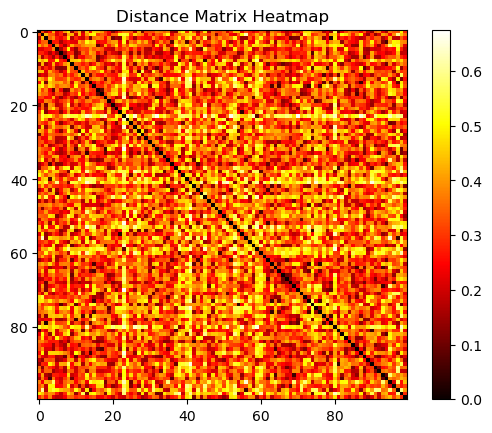

In [3]:
import matplotlib.pyplot as plt

# Load JSON data
with open('client_data.json', 'r') as file:
    data = json.load(file)

# Define epsilon
epsilon = 1e-10

# Extract and preprocess class distributions
distributions = []
ids = []

for item in data:
    ids.append(item['id'])
    class_dist = item['class_distribution']
    sorted_class_counts = [class_dist[str(i)] if str(i) in class_dist else 0 for i in range(10)]
    class_distribution = [(count if count > 0 else epsilon) for count in sorted_class_counts]
    distributions.append(np.array(class_distribution))

# Calculate the pairwise KL divergence distance matrix
num_distributions = len(distributions)
distance_matrix = np.zeros((num_distributions, num_distributions))

for i in range(num_distributions):
    for j in range(i + 1, num_distributions):
        distance_matrix[i, j] = jensen_shannon_divergence(distributions[i], distributions[j])
        distance_matrix[j, i] = distance_matrix[i, j]
        
# Visualize the distance matrix to help choose `eps`
plt.imshow(distance_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Distance Matrix Heatmap")
plt.show()


In [27]:
# Function to try different eps and min_samples
def try_dbscan(eps, min_samples):
    db = DBSCAN(metric='precomputed', eps=eps, min_samples=min_samples)
    labels = db.fit_predict(distance_matrix)
    if len(set(labels)) > 1 and -1 not in labels:
        silhouette_avg = silhouette_score(distance_matrix, labels, metric='precomputed')
        print(f"eps: {eps}, min_samples: {min_samples}, Silhouette Score: {silhouette_avg}")
        return labels, silhouette_avg
    else:
        print(f"eps: {eps}, min_samples: {min_samples}, resulted in a single cluster or noise")
        return labels, None

# Try different eps and min_samples values
best_labels = None
best_score = -1
best_eps = None
best_min_samples = None

eps_values = np.linspace(0.1, 1, 50)  # Further expanded range
min_samples_values = range(2, 15)  # Expanded range

for eps in eps_values:
    for min_samples in min_samples_values:
        labels, score = try_dbscan(eps, min_samples)
        if score is not None and score > best_score:
            best_labels = labels
            best_score = score
            best_eps = eps
            best_min_samples = min_samples

if best_labels is not None:
    print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}, Best Silhouette Score: {best_score}")

    # Group IDs by cluster
    clusters = defaultdict(list)
    for id, cluster in zip(ids, best_labels):
        clusters[cluster].append(id)

    # Print the IDs present in each cluster
    for cluster, ids in clusters.items():
        print(f"Cluster {cluster}: {ids}")
else:
    print("No suitable clustering found.")

eps: 0.1, min_samples: 2, Silhouette Score: 0.9999994508168044
eps: 0.1, min_samples: 3, Silhouette Score: 0.9999994508168044
eps: 0.1, min_samples: 4, Silhouette Score: 0.9999994508168044
eps: 0.1, min_samples: 5, Silhouette Score: 0.9999994508168044
eps: 0.1, min_samples: 6, Silhouette Score: 0.9999994508168044
eps: 0.1, min_samples: 7, Silhouette Score: 0.9999994508168044
eps: 0.1, min_samples: 8, Silhouette Score: 0.9999994508168044
eps: 0.1, min_samples: 9, Silhouette Score: 0.9999994508168044
eps: 0.1, min_samples: 10, Silhouette Score: 0.9999994508168044
eps: 0.1, min_samples: 11, Silhouette Score: 0.9999994508168044
eps: 0.1, min_samples: 12, Silhouette Score: 0.9999994508168044
eps: 0.1, min_samples: 13, Silhouette Score: 0.9999994508168044
eps: 0.1, min_samples: 14, Silhouette Score: 0.9999994508168044
eps: 0.11836734693877551, min_samples: 2, Silhouette Score: 0.9999994508168044
eps: 0.11836734693877551, min_samples: 3, Silhouette Score: 0.9999994508168044
eps: 0.11836734693

In [4]:
from collections import defaultdict
from sklearn.metrics import silhouette_score

# Apply DBSCAN
eps = 0.01  # Example value, needs tuning
min_samples = 10  # Example value, needs tuning
db = DBSCAN(metric='precomputed', eps=eps, min_samples=min_samples)
labels = db.fit_predict(distance_matrix)

# Group IDs by cluster
clusters = defaultdict(list)
for id, cluster in zip(ids, labels):
    clusters[cluster].append(id)

# Print the IDs present in each cluster
for cluster, ids in clusters.items():
    print(f"Cluster {cluster}: {ids}")
    print()
    
# Calculate silhouette score
if len(set(labels)) > 1:
    silhouette_avg = silhouette_score(distance_matrix, labels, metric='precomputed')
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("Silhouette Score cannot be calculated for a single cluster.")

Cluster -1: ['0', '2', '64', '10', '37', '42', '13', '54', '39', '18', '20', '31', '34', '30', '7', '21', '97', '55', '89', '82', '75', '8', '47', '93', '19', '71', '61', '11', '22', '76', '57', '3', '33', '17', '38', '50', '14', '79', '16', '85', '88', '25', '87', '5', '69', '96', '12', '45', '23', '78', '66', '51', '94', '49', '73', '63', '26', '90', '56', '80', '59', '84', '70', '81', '65', '15', '35', '60', '28', '95', '91', '67', '92', '36', '29', '41', '4', '40', '72', '46', '77', '9', '1', '99', '68', '98', '53', '43', '86', '74', '6', '32', '24', '52', '62', '48', '44', '83', '58', '27']

Silhouette Score cannot be calculated for a single cluster.
